# Homework1: StockPricePrediction
The stock we choose is: **01913 PRADA**

### Correlated assets
- Indices
- Industry component stocks
- Stock historical prices

### Procedure
- [Data PreProcessing](#0)
- Model Selection
- Model Tuning
- Visualisation

<a id='0'></a>
## Data Preprocessing
### Data Importing

#### 1. Indices Codes
As the data set contains 2000+ information. First, we need extract the indices data from the data set.

In [6]:
import requests
import re
import json
# import pandas as pd
import os

# data is catched from eastmoney, contains 200+ indices code
url = 'http://13.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124029175978392917634_1679021002481&pn=1&pz=300&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&wbp2u=|0|0|0|web&fid=f3&fs=m:124,m:125,m:305'

response = requests.get(url)

# extract body
content = str(response.content, 'UTF-8')
body = re.findall(r'[(](.*?)\);$', content)[0]

resp = json.loads(body)
data = resp['data']
indexes = data['diff']

codes = []
for i in indexes:
    codes.append(i['f12'])

# output = pd.DataFrame({'code': codes})
# output.to_csv('HKIndices.csv', index=False)

# compare to the data
indiceCode = []
filename_raw = os.listdir('data')
for i in filename_raw:
    matchObj = re.match(r'(.*)\.csv', i)
    if matchObj:
        value = matchObj.group(1)
        if value in codes:
          indiceCode.append(value)

# indices code in data set
indiceCode

['CES100', 'CES120', 'CES280', 'CES300', 'CESA80', 'CESG10', 'HSI', 'VHSI']

From the above output, we can see that only 8 remained indices. 
The codes which begin with `CES` are related to the mainland assets, and we are not interested about them.

So, the remain codes are `HSI` and `VHSI`. 
- `HSI`: stands for Hang Seng Index, which is a stock market index that represents the performance of the Hong Kong stock market
- `VHSI`: (Volatility Index of Hang Seng Index) is an index that measures the expected volatility of the Hang Seng Index (HSI)

#### 2. Industry component stocks
We find some relative stocks about luxury goods.

| code | name |
|---------|---------|
| 00590 | 六福集团  |
| 00887 | 英皇钟表珠宝  |
| 01929 | 周大福  |
| 00116 | 周生生  |
| 03389 | 亨得利  |
| 00280 | 景福集团  |
| 00398 | 东方表行集团 |
| 01856 | 依波路  |

#### 3. Loading data
This section combines the above data into one sheet.


In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import seaborn as sns

# weekly returns, using 5 business day period returns.
return_period = 5
# data head
head_name = ['date', 'open', 'high', 'low', 'close', 'volumn', 'amount']

# data Y: PRADA Future Returns
stk_data = pd.read_csv('data/01913.csv', names = head_name)
# Y = stk_data.loc[:, ['date', 'close']]
Y = np.log(stk_data.loc[:, ('close')]).diff(return_period).\
    shift(-return_period)
Y = pd.concat([stk_data['date'], Y], axis='columns')
Y.columns = ['date', 'PRADA_pred']

# data X1, X2: HSI, VHSI, -5 time
idx_data1 = pd.read_csv('data/HSI.csv', names = head_name)
idx_data2 = pd.read_csv('data/VHSI.csv', names = head_name)
X1 = np.log(idx_data1.loc[:, ('close')]).diff(return_period)
X1 = pd.concat([idx_data1['date'], X1], axis='columns')
X1.columns = ['date', 'lnHSI']
X2 = np.log(idx_data2.loc[:, ('close')]).diff(return_period)
X2 = pd.concat([idx_data2['date'], X2], axis='columns')
X2.columns = ['date', 'lnVHSI']
# inner join by date
idx_X = pd.merge(X2, X1, on='date', how='left')

# data X3, X4, X5: prada-15, prada-30, para-60 lagged dayReturns
X3 = np.log(stk_data.loc[:, ('close')]).shift(-return_period)
X4 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*3)
X5 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*6)
X6 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*12)
lagged_X = pd.concat([stk_data['date'], X3, X4, X5, X6], axis='columns')
lagged_X.columns = ['date', 'PRADA-5', 'PRADA-15', 'PRADA-30', 'PRADA-60']

# todo industry component stock
# data X7 ~ X15: relative component stocks
x7_data = pd.read_csv('data/00590.csv', names = head_name)
X7 = np.log(x7_data.loc[:, ['close']]).shift(-return_period)
X7 = pd.concat([x7_data['date'], X7], axis='columns')
X7.columns = ['date', 'LukFook']
x8_data = pd.read_csv('data/00887.csv', names = head_name)
X8 = np.log(x8_data.loc[:, ['close']]).shift(-return_period)
X8 = pd.concat([x8_data['date'], X8], axis='columns')
X8.columns = ['date', 'EmperorWJ']
x9_data = pd.read_csv('data/01929.csv', names = head_name)
X9 = np.log(x9_data.loc[:, ['close']]).shift(-return_period)
X9 = pd.concat([x9_data['date'], X9], axis='columns')
X9.columns = ['date', 'ChowTaiFook']
x10_data = pd.read_csv('data/00116.csv', names = head_name)
X10 = np.log(x10_data.loc[:, ['close']]).shift(-return_period)
X10 = pd.concat([x10_data['date'], X10], axis='columns')
X10.columns = ['date', 'ChowSangSang']
x11_data = pd.read_csv('data/03389.csv', names = head_name)
X11 = np.log(x11_data.loc[:, ['close']]).shift(-return_period)
X11 = pd.concat([x11_data['date'], X11], axis='columns')
X11.columns = ['date', 'Hengdeli']
x12_data = pd.read_csv('data/00280.csv', names = head_name)
X12 = np.log(x12_data.loc[:, ['close']]).shift(-return_period)
X12 = pd.concat([x12_data['date'], X12], axis='columns')
X12.columns = ['date', 'KingFook']
x13_data = pd.read_csv('data/00398.csv', names = head_name)
X13 = np.log(x13_data.loc[:, ['close']]).shift(-return_period)
X13 = pd.concat([x13_data['date'], X13], axis='columns')
X13.columns = ['date', 'OrientalW']
x14_data = pd.read_csv('data/01856.csv', names = head_name)
X14 = np.log(x14_data.loc[:, ['close']]).shift(-return_period)
X14 = pd.concat([x14_data['date'], X14], axis='columns')
X14.columns = ['date', 'ERNESTBOREL']

dataset = pd.merge(Y, idx_X, on='date', how='right')
dataset = pd.merge(dataset, lagged_X, on='date', how='left')
dataset = pd.merge(dataset, X7, on='date', how='left')
dataset = pd.merge(dataset, X8, on='date', how='left')
dataset = pd.merge(dataset, X9, on='date', how='left')
dataset = pd.merge(dataset, X10, on='date', how='left')
dataset = pd.merge(dataset, X11, on='date', how='left')
dataset = pd.merge(dataset, X12, on='date', how='left')
dataset = pd.merge(dataset, X13, on='date', how='left')
dataset = pd.merge(dataset, X14, on='date', how='left')
dataset = dataset.dropna()

### Data Analysis
#### Descriptive Statistics

In [49]:
dataset.describe()

,PRADA_pred,lnVHSI,lnHSI,PRADA-5,PRADA-15,PRADA-30,PRADA-60,LukFook,EmperorWJ,ChowTaiFook,ChowSangSang,Hengdeli,KingFook,OrientalW,ERNESTBOREL
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,-0.004264,0.002702,0.001804,3.438131,3.428830,3.419917,3.407441,3.118284,-1.279779,1.976702,2.774561,-0.069947,-0.412457,0.273065,0.561089
std,0.049982,0.133587,0.025191,0.229622,0.223080,0.216082,0.200979,0.210611,0.275722,0.234711,0.159702,0.407785,0.206587,0.226212,0.209776
min,-0.141015,-0.454371,-0.113870,3.015535,3.015535,3.032546,3.013081,2.551006,-1.910543,1.446919,2.394252,-0.994252,-0.776529,-0.116534,0.039221
25%,-0.035817,-0.071407,-0.013629,3.267666,3.267666,3.267666,3.273364,2.954910,-1.435485,1.754404,2.664447,-0.301105,-0.527633,0.076961,0.438255
50%,-0.003578,-0.011101,0.003763,3.363842,3.351657,3.351657,3.363842,3.113515,-1.220780,2.026832,2.782539,-0.094311,-0.446287,0.307485,0.530628
75%,0.024460,0.054833,0.016757,3.613617,3.591818,3.565298,3.499533,3.297687,-1.049822,2.158715,2.890372,0.223144,-0.301105,0.494696,0.678034
max,0.216699,0.864305,0.110608,3.948355,3.948355,3.948355,3.948355,3.572346,-0.744440,2.397895,3.068053,0.698135,0.254642,0.625938,1.178655


In [50]:
dataset.head()

,date,PRADA_pred,lnVHSI,lnHSI,PRADA-5,PRADA-15,PRADA-30,PRADA-60,LukFook,EmperorWJ,ChowTaiFook,ChowSangSang,Hengdeli,KingFook,OrientalW,ERNESTBOREL
5,2014/11/19,0.042820,-0.055003,-0.023880,3.914021,3.794365,3.787593,3.750680,3.144152,-1.049822,2.375836,3.005683,0.385262,-0.040822,0.500775,1.178655
6,2014/11/20,0.045950,-0.099178,-0.028303,3.914021,3.781914,3.772761,3.751854,3.242592,-1.035637,2.379546,3.039749,0.371564,-0.051293,0.494696,1.121678
7,2014/11/21,0.028285,-0.205002,-0.027367,3.916015,3.787593,3.760037,3.751854,3.238678,-1.035637,2.381396,3.046901,0.405465,-0.051293,0.494696,1.043804
8,2014/11/24,0.007089,-0.090085,0.004029,3.902982,3.789855,3.740048,3.789855,3.228826,-1.035637,2.388763,3.025291,0.418710,-0.083382,0.494696,1.022451
9,2014/11/25,-0.018127,-0.147677,0.013069,3.895894,3.793239,3.757706,3.794365,3.228826,-1.021651,2.377693,3.025291,0.405465,-0.105361,0.494696,1.036737


#### Data Visualization

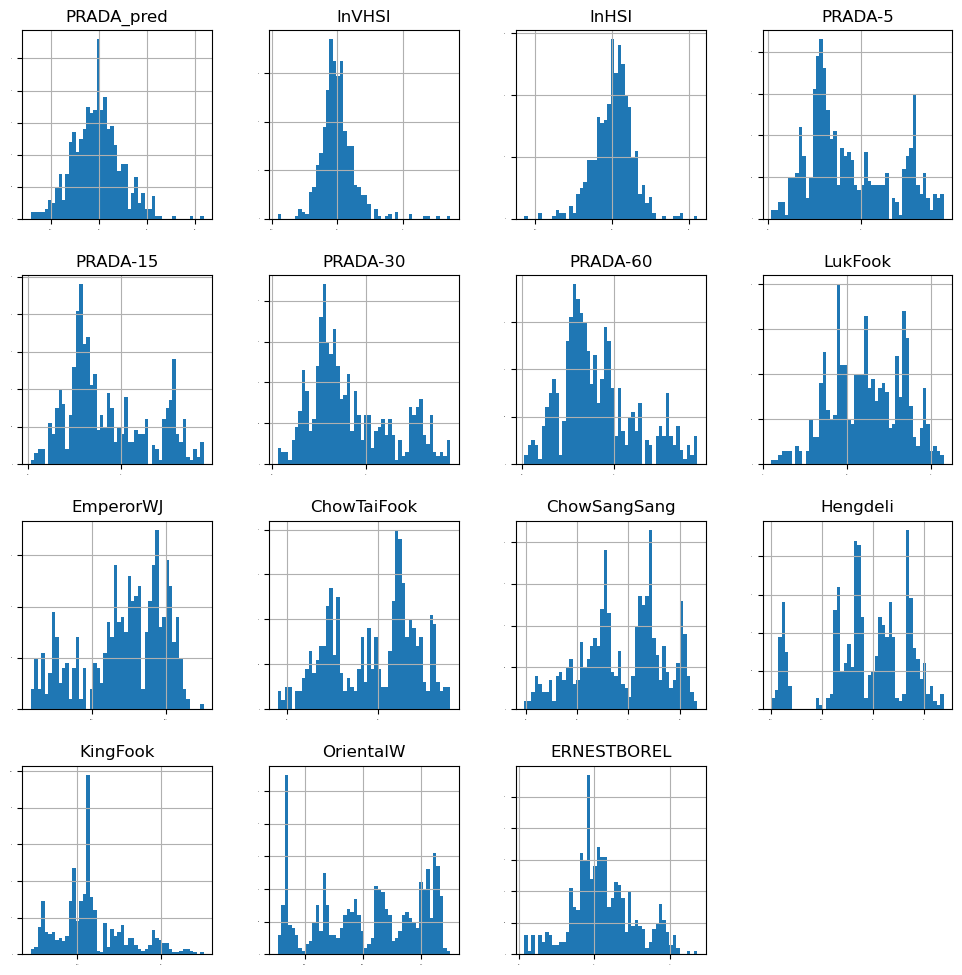

In [51]:
# Make a histogram of the DataFrame’s columns
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each columns. Next we see the density distribution over the same x axis scale.

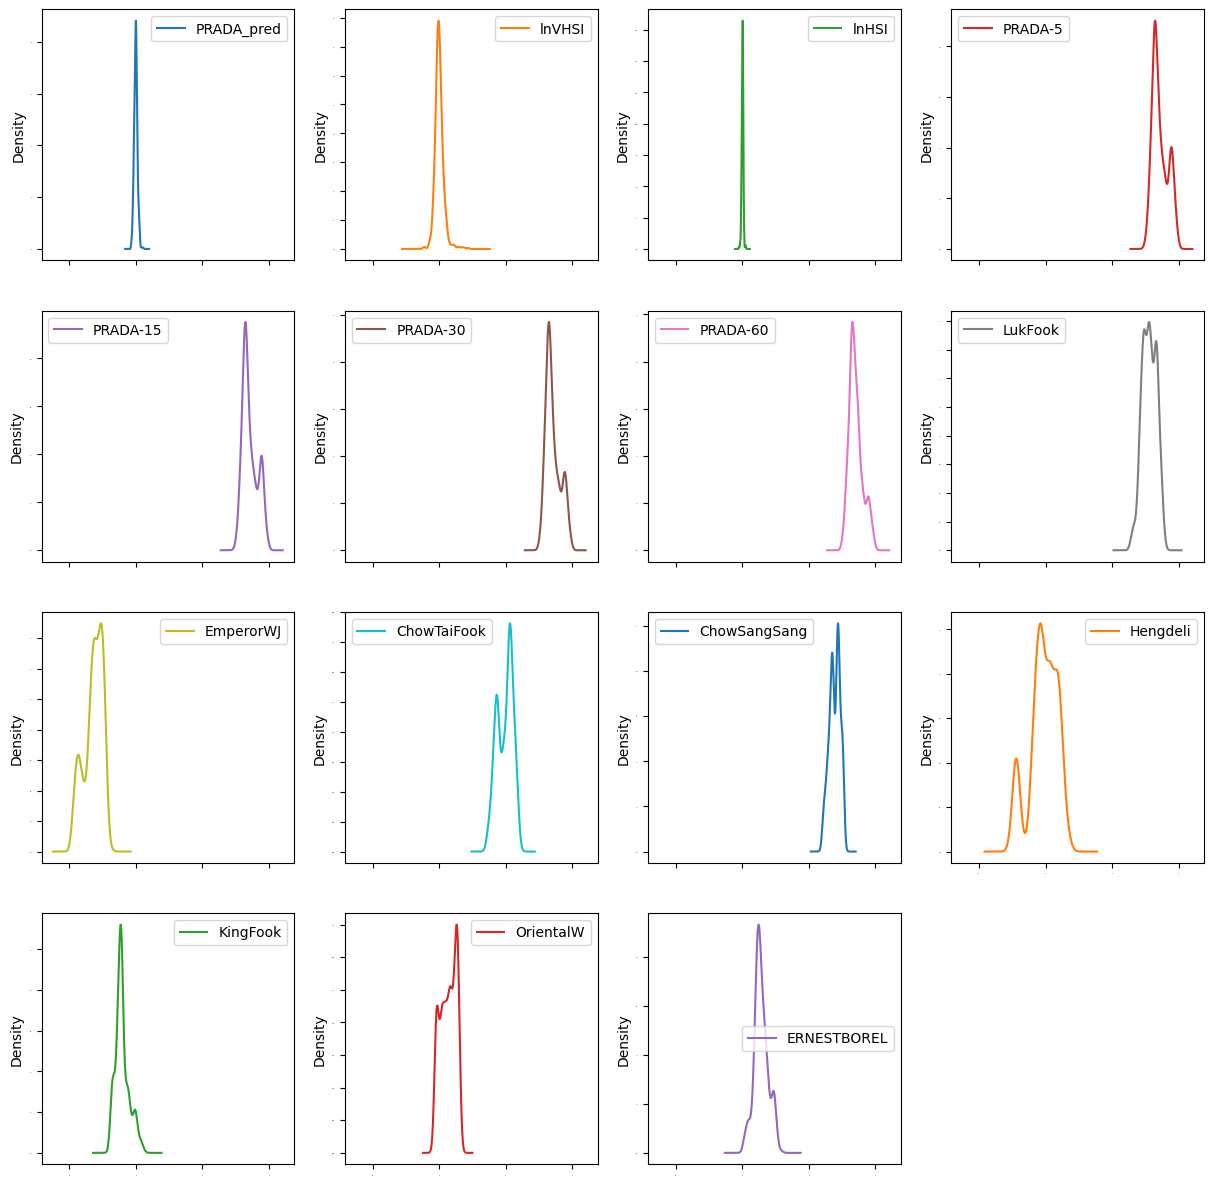

In [52]:
# show the density distribution
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Then we look at the scatter plot and the correlation matrix to get a sense of the interdependence of the data.

<AxesSubplot:title={'center':'Correlation Matrix'}>

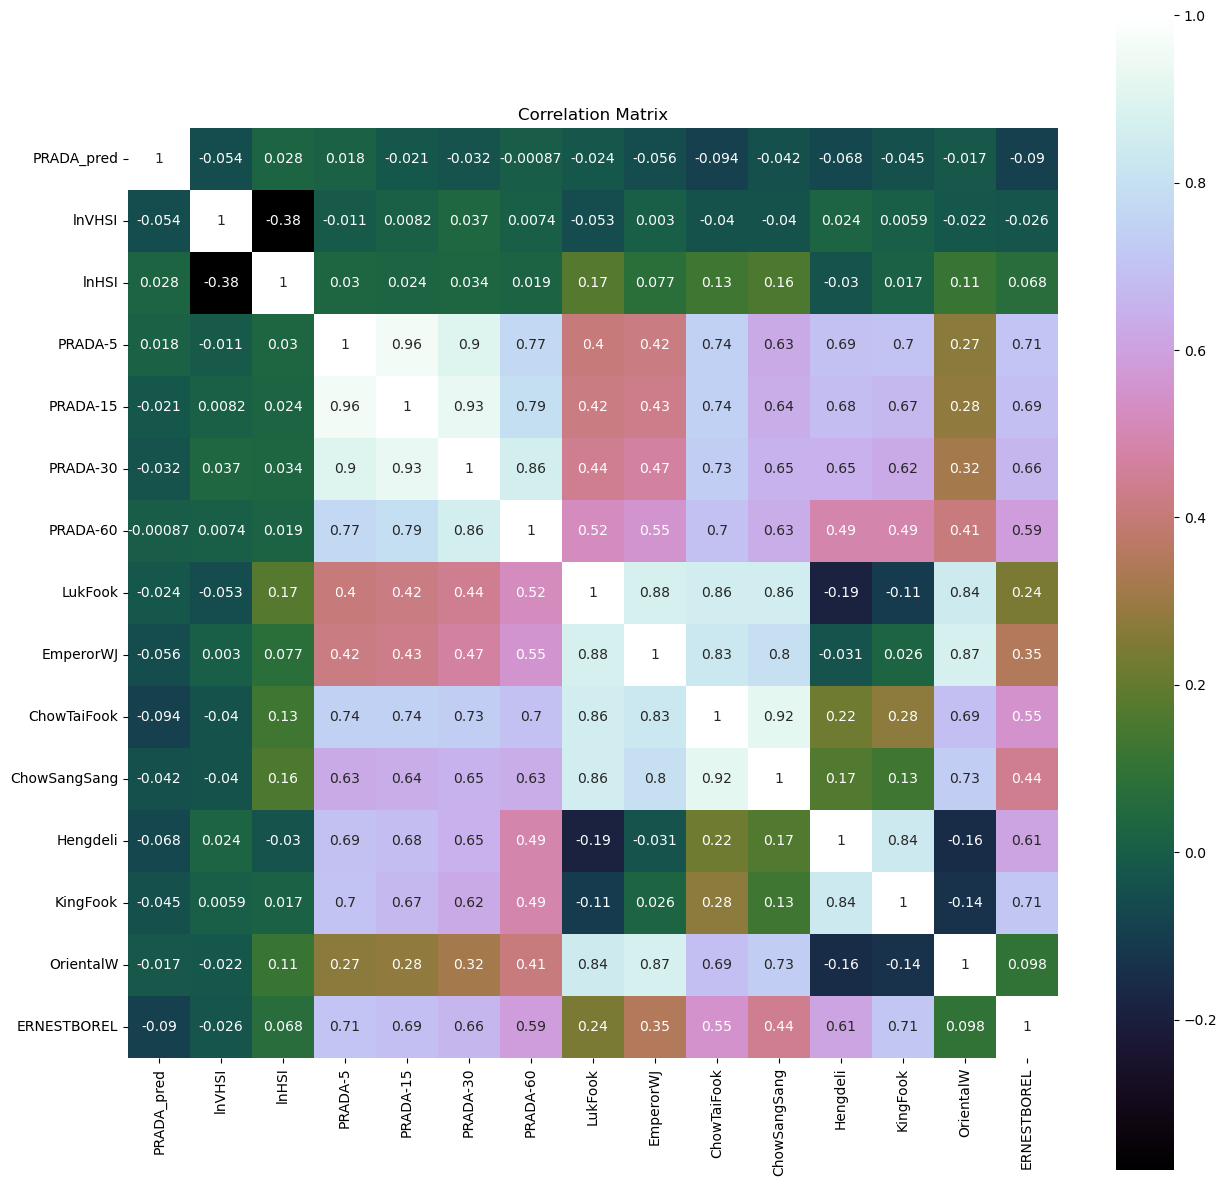

In [53]:
# Compute pairwise correlation of columns, excluding NA/null values
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

We can see that EmperorWJ, LukFook, ChowSangSang, OrientalW, ChowTaiFook have corelation whit VHSI, lets delete them and see the result.

<AxesSubplot:title={'center':'Correlation Matrix'}>

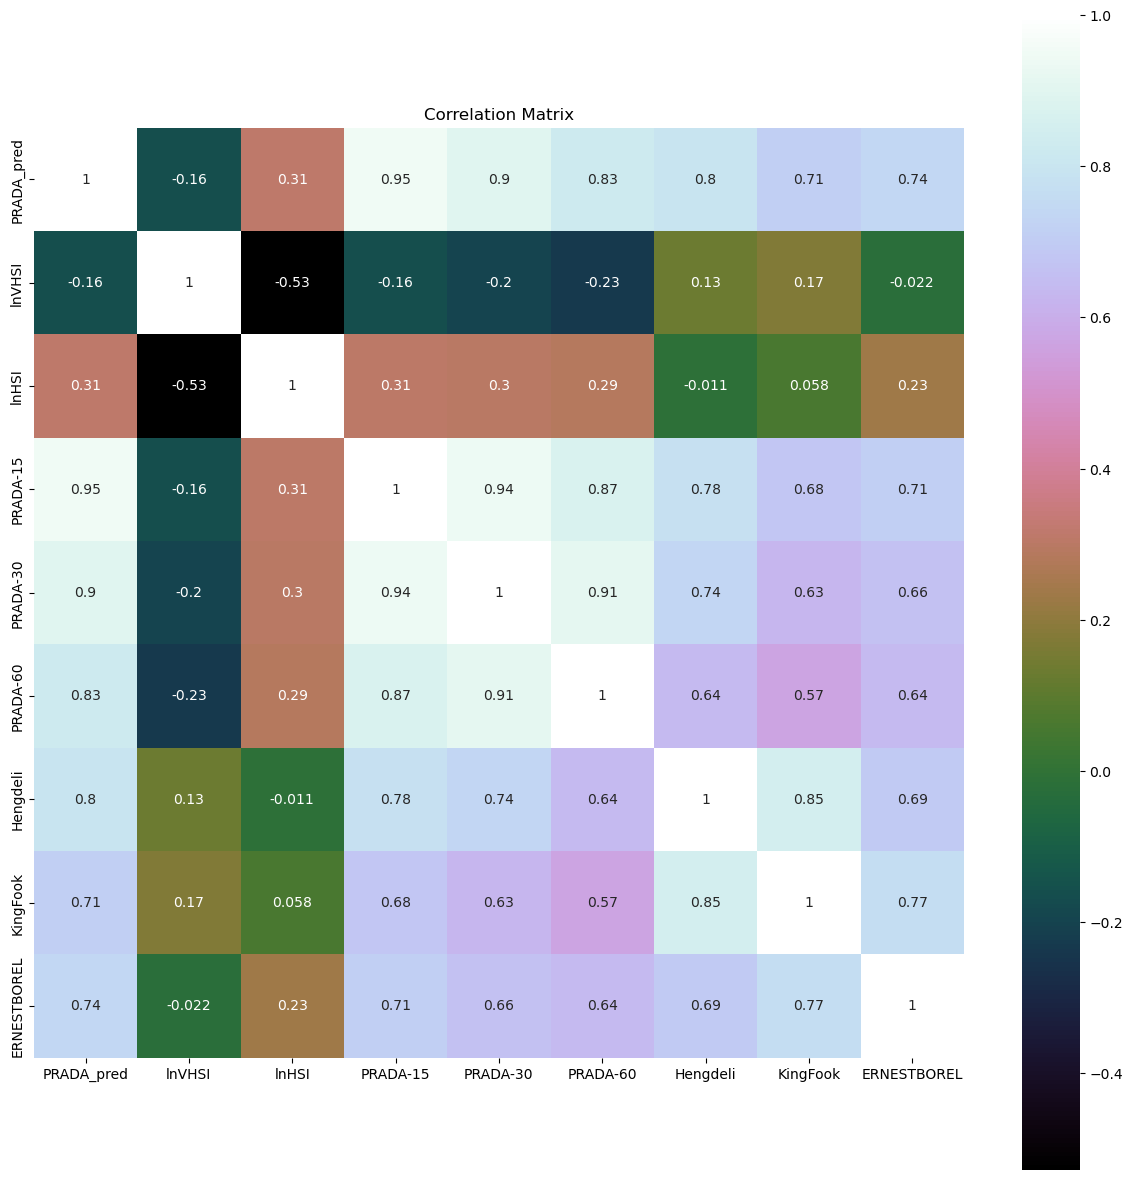

In [47]:
dataset_1 = dataset.drop(columns=['EmperorWJ', 'LukFook', 'ChowSangSang', 'OrientalW', 'ChowTaiFook'])
# show the Correlation Matrix again
# Compute pairwise correlation of columns, excluding NA/null values
correlation = dataset_1.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')